# Introduction

The [Zillow Prize](https://www.zillow.com/promo/Zillow-prize/) is a [Kaggle competition](https://www.kaggle.com/c/zillow-prize-1) that aims to inspire data scientists around the world to improve the accuracy of the Zillow "Zestimate" statistical and machine learning models. 

My goal is to compete for the Zillow prize and write up my results.

# Methods

## Data

The data were obtained from [Kaggle website](https://www.kaggle.com/c/zillow-prize-1/data) and consist of the following files:

- properties_2016.csv.zip
- properties_2017.csv.zip
- sample_submission.csv
- train_2016_v2.csv.zip
- train_2017.csv.zip
- zillow_data_dictionary.xlsx

The `zillow_data_dictionary.xlsx` is a code book that explains the data.
This data will be made available on [figshare](https://figshare.com/) to provide an additional source if the [Kaggle site data](https://www.kaggle.com/c/zillow-prize-1/data) become unavailable.

## Analysis

Data analysis was done in Jupyter Notebook (formerly known as IPython Notebook) <cite data-cite="5251998/SH25XT8L"></cite> Integrated Development Environment using the Python language <cite data-cite="5251998/FGTD82L2"></cite> and a number of software packages:

- NumPy <cite data-cite="5251998/3SWILWGR"></cite>
- Pandas <cite data-cite="5251998/K3NZPGU9"></cite>
- Scikit-learn (Pedregosa et al. 2011)


## Visualization

The following packages were used to visualize the data:

- Matplotlib <cite data-cite="5251998/WP5LZ6AZ"></cite>
- Seaborn 
- r-ggplot2
- r-cowplot

The use of `R` code and packages in a `Python` environment is possible through the use of the `Rpy2` package.

## Prediction

Machine learning prediction was done using the following packages:

- scikit-learn (Pedregosa et al. 2011)
- xgboost
- r-caret 

### Reproducibility

Reproducibility is extremely important in scientific research yet many examples of problematic studies exist in the literature (Couzin-Frankel 2010)<cite data-cite="5251998/UXR4ZTUS"></cite>.

The names and versions of each package used herein are listed in the accompanying `env.yml` file in the `config` folder.
The computational environment used to analyze the data can be recreated using this `env.yml` file and the [`conda` package and environment manager](https://conda.io/docs/using/envs.html) available as part of the [Anaconda distribution of Python](https://www.anaconda.com/download/).

Additionally, details on how to setup a Docker image capable of running the analysis is included in the `README.md` file in the `config` folder.

The code in the form of a jupyter notebook (`01_zillow_MWS.ipynb`) or Python script (`01_zillow_MWS.py`), can also be run on the Kaggle website (this requires logging in with a username and password).

More information on the details of how this project was created and the computational environment was configured can be found in the accompanying `README.md` file.

This Python 3 environment comes with many helpful analytics libraries installed
It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python (a modified version of this docker image will be made available as part of my project to ensure reproducibility).
For example, here's several helpful packages to load in 

# Results

There are several columns which have a very high proportion of missing values. I will remove features that have more than 80% missing values.

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [26]:
# Set plot parameters
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"
%matplotlib inline
### Seaborn style
sns.set_style("whitegrid")

In [ ]:
#Input data files are available in the "../input/" directory, on Kaggle and this repo.
prop = pd.read_csv("../input/properties_2016.csv", low_memory=False)
prop.shape;

In [6]:
### ... check for NaNs
nan = prop.isnull().sum()/len(prop)*100

In [7]:
### Plotting NaN counts
nan_sorted = nan.sort_values(ascending=False).to_frame().reset_index()
nan_sorted.columns = ['Column', 'percentNaN']
nan_sorted.head();

In [ ]:
## Missing Values

fig, ax = plt.subplots(figsize=(6, 12.5), dpi=300)
sns.barplot(x="percentNaN", y="Column", data=nan_sorted, color='Blue', ax=ax)
ax.set(xlabel="Missing Values (%)", ylabel="", title="Percent Missing Values in each column")
ax.xaxis.grid()
plt.show()

In [21]:
train = pd.read_csv("../input/train_2016_v2.csv", parse_dates=["transactiondate"])
train.shape;

In [22]:
train['transaction_month'] = pd.DatetimeIndex(train['transactiondate']).month
train.sort_values('transaction_month', axis=0, ascending=True, inplace=True)

In [23]:
#fill NaN values with -1 and encode object columns 
for x in prop.columns:
    prop[x] = prop[x].fillna(-1)

#many more parcelids in properties file, merge with training file
train = pd.merge(train, prop, on='parcelid', how='left')


In [ ]:
## Feature Importance by Random Forest and Xgboost

In [24]:
for c in train[['transactiondate', 'hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']]:
    label = LabelEncoder()
    label.fit(list(train[c].values))
    train[c] = label.transform(list(train[c].values))

x_train = train.drop(['parcelid', 'logerror', 'transactiondate'], axis=1)
y_train = train['logerror']

In [25]:
rf = RandomForestRegressor(n_estimators=30, max_features=None)
rf.fit(x_train, y_train);

In [34]:
rf_importance = rf.feature_importances_
rf_importance_df = pd.DataFrame()
rf_importance_df['features'] = x_train.columns
rf_importance_df['importance'] = rf_importance
rf_importance_df.head();

In [35]:
rf_importance_df.sort_values('importance', axis=0, inplace=True, ascending=False)

rf_importance_df.head();

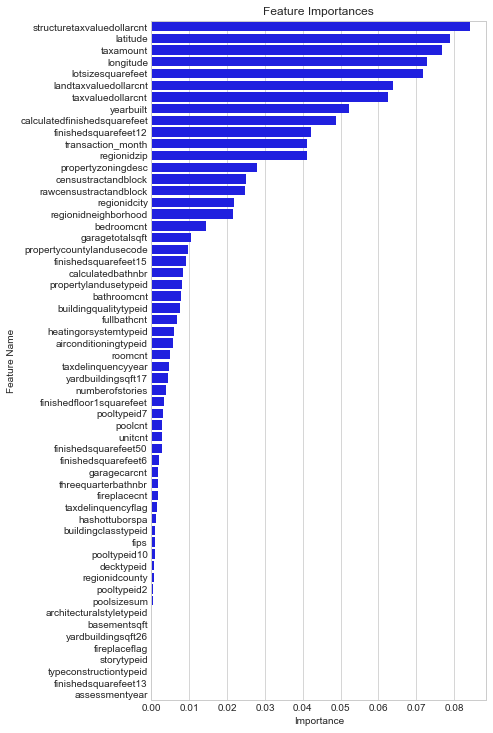

In [14]:
fig, ax = plt.subplots(figsize=(6, 12.5))
sns.barplot(x="importance", y="features", data=rf_importance_df, color='Blue', ax=ax)
ax.set(xlabel="Importance", ylabel="Feature Name", title="Feature Importances")
plt.show()

In [28]:
etr = ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
etr.fit(x_train, y_train);

In [32]:
etr_importance = etr.feature_importances_
etr_importance_df = pd.DataFrame()
etr_importance_df['features'] = x_train.columns
etr_importance_df['importance'] = etr_importance
etr_importance_df.head();

In [33]:
etr_importance_df.sort_values('importance', axis=0, inplace=True, ascending=False)
etr_importance_df.head();

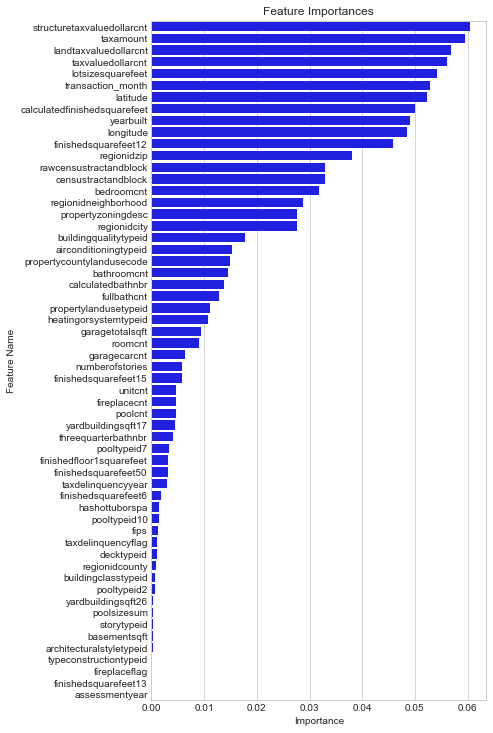

In [18]:
fig, ax = plt.subplots(figsize=(6, 12.5))
sns.barplot(x="importance", y="features", data=etr_importance_df, color='Blue', ax=ax)
ax.set(xlabel="Importance", ylabel="Feature Name", title="Feature Importances")
plt.show()

In [19]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(x_train, y_train, feature_names=x_train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

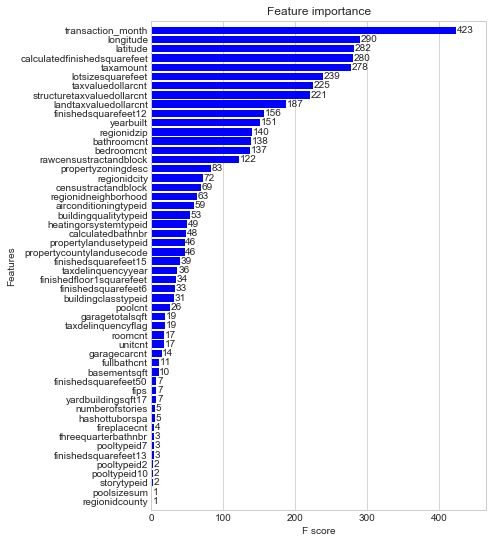

In [20]:
# plot the important features #
fig, ax = plt.subplots(figsize=(6,9))
xgb.plot_importance(model, height=0.8, grid = False, color="blue", ax=ax)
ax.xaxis.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simple data to display in various forms
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

plt.close('all')

# Just a figure and one subplot
f, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x, y)
axarr[0].set_title('Sharing X axis')
axarr[1].scatter(x, y)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing both axes')
ax2.scatter(x, y)
ax3.scatter(x, 2 * y ** 2 - 1, color='r')
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

# row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(x, y)
ax1.set_title('Sharing x per column, y per row')
ax2.scatter(x, y)
ax3.scatter(x, 2 * y ** 2 - 1, color='r')
ax4.plot(x, 2 * y ** 2 - 1, color='r')

# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

# Four polar axes
f, axarr = plt.subplots(2, 2, subplot_kw=dict(projection='polar'))
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')
# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.3)

plt.show()


# Conclusions

In Progress

In [ ]:
# Bibliography is added in post-processing

<div class="cite2c-biblio"></div>